# 人脸识别——通过FaceNet进行人脸相似性计算

本案例中，我们使用`FaceNet`神经网络模型进行人脸相似性计算。

首先，使用`MTCNN`神经网络模型检测出人脸区域，然后使用`FaceNet`卷积神经网络提取出人脸的特征向量，最后根据人脸特征向量计算人脸之间的欧式距离，得到人脸的相似性。

## MTCNN模型简介

[MTCNN（Multi-task convolutional neural network）](https://kpzhang93.github.io/MTCNN_face_detection_alignment/) 中文名称是多任务卷积神经网络，可以用来做人脸区域检测和人脸对齐。在人脸检测中会面临很多不同的问题：遮挡，角度倾斜等。传统方法中，大多使用机器学习的方法，而在MTCNN中，使用深度学习方法结合NMS和边界框回归，将人脸区域坐标和关键点坐标进行识别，相比较机器学习方法，MTCNN能更好地识别不同情况下的人脸。

MTCNN模型的详解可以参考：https://kpzhang93.github.io/MTCNN_face_detection_alignment 。

## 环境准备

### 进入ModelArts

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ， 进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

### 创建ModelArts notebook

下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

|项目|建议填写方式|
|-|-|
|名称|自定义环境名称|
|工作环境 | Python3|
| 资源池 | 选择"公共资源池"即可 |
|类型|GPU|
|规格|v100|
|存储配置|EVS|
|磁盘规格|5GB|

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建”

![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后选择TensorFlow 1.13.1开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"facenet"
![notebook_untitled_filename](./img/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./img/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)


开发环境准备好啦，接下来可以愉快地写代码啦！

## 实践内容

### 数据和代码下载
运行下面代码，进行数据和代码的下载和解压

In [1]:
from modelarts.session import Session
sess = Session()

if sess.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_face_recognition_advanced/face.tar.gz"
elif sess.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_face_recognition_advanced/face.tar.gz"
else:
    print("请更换地区到北京一或北京四")

sess.download_data(bucket_path=bucket_path, path="./face.tar.gz")

Successfully download file modelarts-labs-bj4/notebook/DL_face_recognition_advanced/face.tar.gz from OBS to local ./face.tar.gz


### 解压文件

In [2]:
!tar -xf face.tar.gz

开始案例，首先，对FaceNet进行训练。

In [3]:
import tensorflow as tf
from tensorflow.python.ops import data_flow_ops
import itertools
import numpy as np
import time

from src.facenet import get_dataset, load_data, load_model
from src.train_tripletloss import sample_people, select_triplets, save_variables_and_metagraph

## FaceNet模型搭建和训练

FaceNet论文见此链接：https://arxiv.org/abs/1503.03832

###  FaceNet结构总览

![FaceNet-structure](./img/FN-str-1.png)

在MTCNN将人脸区域识别出来之后，我们使用FaceNet进行人脸特征提取。

完整的FaceNet包括：**批输入层， 深度卷积神经网络，$L^2$范式， EMBEDDING，三重损失函数**，深度卷积网络部分的结构和搭建我们将在下一部分进行讲解，通过深度卷积网络，输入图片的特征图被提取出来，接着计算L2范数。

### embedding

Embedding算法将正整数（下标）转换为具有固定大小的向量


### 三重损失函数Triplet loss      

模型的训练通过三重损失函数来实现。当我们判断两张图片是否为同一个人时，我们判断两张图片中人脸的128维向量的欧式距离是否相近，如果足够相近则判断为同一个人。在FaceNet中，计算三重损失函数训练能够学到较好的人脸的Embedding。三重损失函数的输入分为三部分：**anchor**， **positive**，**negative**。 **anchor**是随机挑选出的数据，**positive**与anchor来自同一类别，而**negative**与anchor类别不同。模型需要判断出三者的关系，将**anchor**和**positive**之间的距离拉近，将**anchor**和**negative**之间的距离推远。

![Triplet-loss -structure](./img/FN-str-2.png)


### FaceNet骨干网络搭建 

In [4]:
# Inception-Resnet-A
def block35(net, scale=1.0, activation_fn=tf.nn.relu, scope=None, reuse=None):
    """Builds the 35x35 resnet block."""
    with tf.variable_scope(scope, 'Block35', [net], reuse=reuse):
        with tf.variable_scope('Branch_0'):
            tower_conv = slim.conv2d(net, 32, 1, scope='Conv2d_1x1')
        with tf.variable_scope('Branch_1'):
            tower_conv1_0 = slim.conv2d(net, 32, 1, scope='Conv2d_0a_1x1')
            tower_conv1_1 = slim.conv2d(tower_conv1_0, 32, 3, scope='Conv2d_0b_3x3')
        with tf.variable_scope('Branch_2'):
            tower_conv2_0 = slim.conv2d(net, 32, 1, scope='Conv2d_0a_1x1')
            tower_conv2_1 = slim.conv2d(tower_conv2_0, 32, 3, scope='Conv2d_0b_3x3')
            tower_conv2_2 = slim.conv2d(tower_conv2_1, 32, 3, scope='Conv2d_0c_3x3')
        mixed = tf.concat([tower_conv, tower_conv1_1, tower_conv2_2], 3)
        up = slim.conv2d(mixed, net.get_shape()[3], 1, normalizer_fn=None,
                         activation_fn=None, scope='Conv2d_1x1')
        net += scale * up
        if activation_fn:
            net = activation_fn(net)
    return net

In [5]:
# Inception-Resnet-B
def block17(net, scale=1.0, activation_fn=tf.nn.relu, scope=None, reuse=None):
    """Builds the 17x17 resnet block."""
    with tf.variable_scope(scope, 'Block17', [net], reuse=reuse):
        with tf.variable_scope('Branch_0'):
            tower_conv = slim.conv2d(net, 128, 1, scope='Conv2d_1x1')
        with tf.variable_scope('Branch_1'):
            tower_conv1_0 = slim.conv2d(net, 128, 1, scope='Conv2d_0a_1x1')
            tower_conv1_1 = slim.conv2d(tower_conv1_0, 128, [1, 7], scope='Conv2d_0b_1x7')
            tower_conv1_2 = slim.conv2d(tower_conv1_1, 128, [7, 1], scope='Conv2d_0c_7x1')
        mixed = tf.concat([tower_conv, tower_conv1_2], 3)
        up = slim.conv2d(mixed, net.get_shape()[3], 1, normalizer_fn=None, activation_fn=None, scope='Conv2d_1x1')
        net += scale * up
        if activation_fn:
            net = activation_fn(net)
    return net

In [6]:
# Inception-Resnet-C
def block8(net, scale=1.0, activation_fn=tf.nn.relu, scope=None, reuse=None):
    """Builds the 8x8 resnet block."""
    with tf.variable_scope(scope, 'Block8', [net], reuse=reuse):
        with tf.variable_scope('Branch_0'):
            tower_conv = slim.conv2d(net, 192, 1, scope='Conv2d_1x1')
        with tf.variable_scope('Branch_1'):
            tower_conv1_0 = slim.conv2d(net, 192, 1, scope='Conv2d_0a_1x1')
            tower_conv1_1 = slim.conv2d(tower_conv1_0, 192, [1, 3],
                                        scope='Conv2d_0b_1x3')
            tower_conv1_2 = slim.conv2d(tower_conv1_1, 192, [3, 1],
                                        scope='Conv2d_0c_3x1')
        mixed = tf.concat([tower_conv, tower_conv1_2], 3)
        up = slim.conv2d(mixed, net.get_shape()[3], 1, normalizer_fn=None,
                         activation_fn=None, scope='Conv2d_1x1')
        net += scale * up
        if activation_fn:
            net = activation_fn(net)
    return net

In [7]:
def reduction_a(net, k, l, m, n):
    with tf.variable_scope('Branch_0'):
        tower_conv = slim.conv2d(net, n, 3, stride=2, padding='VALID',
                                 scope='Conv2d_1a_3x3')
    with tf.variable_scope('Branch_1'):
        tower_conv1_0 = slim.conv2d(net, k, 1, scope='Conv2d_0a_1x1')
        tower_conv1_1 = slim.conv2d(tower_conv1_0, l, 3,
                                    scope='Conv2d_0b_3x3')
        tower_conv1_2 = slim.conv2d(tower_conv1_1, m, 3,
                                    stride=2, padding='VALID',
                                    scope='Conv2d_1a_3x3')
    with tf.variable_scope('Branch_2'):
        tower_pool = slim.max_pool2d(net, 3, stride=2, padding='VALID',
                                     scope='MaxPool_1a_3x3')
    net = tf.concat([tower_conv, tower_conv1_2, tower_pool], 3)
    return net

In [8]:
def reduction_b(net):
    with tf.variable_scope('Branch_0'):
        tower_conv = slim.conv2d(net, 256, 1, scope='Conv2d_0a_1x1')
        tower_conv_1 = slim.conv2d(tower_conv, 384, 3, stride=2,
                                   padding='VALID', scope='Conv2d_1a_3x3')
    with tf.variable_scope('Branch_1'):
        tower_conv1 = slim.conv2d(net, 256, 1, scope='Conv2d_0a_1x1')
        tower_conv1_1 = slim.conv2d(tower_conv1, 256, 3, stride=2,
                                    padding='VALID', scope='Conv2d_1a_3x3')
    with tf.variable_scope('Branch_2'):
        tower_conv2 = slim.conv2d(net, 256, 1, scope='Conv2d_0a_1x1')
        tower_conv2_1 = slim.conv2d(tower_conv2, 256, 3,
                                    scope='Conv2d_0b_3x3')
        tower_conv2_2 = slim.conv2d(tower_conv2_1, 256, 3, stride=2,
                                    padding='VALID', scope='Conv2d_1a_3x3')
    with tf.variable_scope('Branch_3'):
        tower_pool = slim.max_pool2d(net, 3, stride=2, padding='VALID',
                                     scope='MaxPool_1a_3x3')
    net = tf.concat([tower_conv_1, tower_conv1_1,
                        tower_conv2_2, tower_pool], 3)
    return net

In [9]:
import tensorflow.contrib.slim as slim

def inception_resnet_v1(inputs, is_training=True,
                        dropout_keep_prob=0.8,
                        bottleneck_layer_size=128,
                        reuse=None, 
                        scope='InceptionResnetV1'):
    end_points = {}
  
    with tf.variable_scope(scope, 'InceptionResnetV1', [inputs], reuse=reuse):
        with slim.arg_scope([slim.batch_norm, slim.dropout],is_training=is_training):
            with slim.arg_scope([slim.conv2d, slim.max_pool2d, slim.avg_pool2d], stride=1, padding='SAME'):
                # stem 部分
                # 149 x 149 x 32
                net = slim.conv2d(inputs, 32, 3, stride=2, padding='VALID', scope='Conv2d_1a_3x3')
                end_points['Conv2d_1a_3x3'] = net
                # 147 x 147 x 32
                net = slim.conv2d(net, 32, 3, padding='VALID', scope='Conv2d_2a_3x3')
                end_points['Conv2d_2a_3x3'] = net 
                # 147 x 147 x 64
                net = slim.conv2d(net, 64, 3, scope='Conv2d_2b_3x3')
                end_points['Conv2d_2b_3x3'] = net                
                # 73 x 73 x 64
                net = slim.max_pool2d(net, 3, stride=2, padding='VALID', scope='MaxPool_3a_3x3')
                end_points['MaxPool_3a_3x3'] = net                
                # 73 x 73 x 80
                net = slim.conv2d(net, 80, 1, padding='VALID', scope='Conv2d_3b_1x1')
                end_points['Conv2d_3b_1x1'] = net
                # 71 x 71 x 192
                net = slim.conv2d(net, 192, 3, padding='VALID', scope='Conv2d_4a_3x3')
                end_points['Conv2d_4a_3x3'] = net
                # 35 x 35 x 256
                net = slim.conv2d(net, 256, 3, stride=2, padding='VALID', scope='Conv2d_4b_3x3')
                end_points['Conv2d_4b_3x3'] = net

                # Inception-resnet-A 部分
                net = slim.repeat(net, 5, block35, scale=0.17)
                end_points['Mixed_5a'] = net
        
                # Reduction-A
                with tf.variable_scope('Mixed_6a'):
                    net = reduction_a(net, 192, 192, 256, 384)
                end_points['Mixed_6a'] = net
                
                # Inception-Resnet-B 部分
                net = slim.repeat(net, 10, block17, scale=0.10)
                end_points['Mixed_6b'] = net
                
                # Reduction-B
                with tf.variable_scope('Mixed_7a'):
                    net = reduction_b(net)
                end_points['Mixed_7a'] = net
                
                # Inception-Resnet-C 部分
                net = slim.repeat(net, 5, block8, scale=0.20)
                end_points['Mixed_8a'] = net
                
                net = block8(net, activation_fn=None)
                end_points['Mixed_8b'] = net
                
                with tf.variable_scope('Logits'):
                    end_points['PrePool'] = net
                    #pylint: disable=no-member
                    net = slim.avg_pool2d(net, net.get_shape()[1:3], padding='VALID',
                                          scope='AvgPool_1a_8x8')
                    net = slim.flatten(net)
          
                    net = slim.dropout(net, dropout_keep_prob, is_training=is_training, scope='Dropout')
          
                    end_points['PreLogitsFlatten'] = net
                
                net = slim.fully_connected(net, bottleneck_layer_size, activation_fn=None, 
                        scope='Bottleneck', reuse=False)
  
    return net, end_points
tf.reset_default_graph()
inputs = tf.placeholder(tf.float32, shape=(None, 229, 229, 3))
net, end_points = inception_resnet_v1(inputs)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


查看模型结构信息

In [10]:
end_points

{'Conv2d_1a_3x3': <tf.Tensor 'InceptionResnetV1/Conv2d_1a_3x3/Relu:0' shape=(?, 114, 114, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionResnetV1/Conv2d_2a_3x3/Relu:0' shape=(?, 112, 112, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionResnetV1/Conv2d_2b_3x3/Relu:0' shape=(?, 112, 112, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionResnetV1/Conv2d_3b_1x1/Relu:0' shape=(?, 55, 55, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionResnetV1/Conv2d_4a_3x3/Relu:0' shape=(?, 53, 53, 192) dtype=float32>,
 'Conv2d_4b_3x3': <tf.Tensor 'InceptionResnetV1/Conv2d_4b_3x3/Relu:0' shape=(?, 26, 26, 256) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionResnetV1/MaxPool_3a_3x3/MaxPool:0' shape=(?, 55, 55, 64) dtype=float32>,
 'Mixed_5a': <tf.Tensor 'InceptionResnetV1/Repeat/block35_5/Relu:0' shape=(?, 26, 26, 256) dtype=float32>,
 'Mixed_6a': <tf.Tensor 'InceptionResnetV1/Mixed_6a/concat:0' shape=(?, 12, 12, 896) dtype=float32>,
 'Mixed_6b': <tf.Tensor

### 构建TensorFlow计算图

In [11]:
def inference(images, keep_probability, phase_train=True,
              bottleneck_layer_size=128, weight_decay=0.0, reuse=None):
    batch_norm_params = {
        # Decay for the moving averages.
        'decay': 0.995,
        # epsilon to prevent 0s in variance.
        'epsilon': 0.001,
        # force in-place updates of mean and variance estimates
        'updates_collections': None,
        # Moving averages ends up in the trainable variables collection
        'variables_collections': [ tf.GraphKeys.TRAINABLE_VARIABLES ],
    }

    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                        weights_initializer=slim.initializers.xavier_initializer(),
                        weights_regularizer=slim.l2_regularizer(weight_decay),
                        normalizer_fn=slim.batch_norm,
                        normalizer_params=batch_norm_params):
        return inception_resnet_v1(images, is_training=phase_train,
              dropout_keep_prob=keep_probability, bottleneck_layer_size=bottleneck_layer_size, reuse=reuse)

创建一个新的Graph，全局步数为0

In [12]:
tf.reset_default_graph()
global_step = tf.Variable(0, trainable=False)

创建变量的占位符

In [13]:
learning_rate_placeholder = tf.placeholder(tf.float32, name='learning_rate')
batch_size_placeholder = tf.placeholder(tf.int32, name='batch_size')
phase_train_placeholder = tf.placeholder(tf.bool, name='phase_train')
image_paths_placeholder = tf.placeholder(tf.string, shape=(None,3), name='image_paths')
labels_placeholder = tf.placeholder(tf.int64, shape=(None,3), name='labels')

设置超参，可以根据不同情况进行调节

In [14]:
# 训练数据路径
data_dir = './data/CASIA-maxpy-clean/'
# 预训练模型位置
pretrained_model = "./20170512-110547/"
# 图片大小
image_size  =160
# 批大小
batch_size = 90
# Embedding维度
embedding_size = 128
# 权重衰减
weight_decay = 0.0

# 学习率
learning_rate = 0.05
# 批处理数量
people_per_batch = 9
images_per_person = 8

## 数据准备

创建enqueue_op，创建数据多线程读取节点。

In [15]:
input_queue = data_flow_ops.FIFOQueue(capacity=100000,
                        dtypes=[tf.string, tf.int64],
                        shapes=[(3,), (3,)],
                        shared_name=None, name=None)
enqueue_op = input_queue.enqueue_many([image_paths_placeholder, labels_placeholder])

图像预处理经过了数据增强：随机切割，随机翻转，以及图片标准化

**数据增强**：通过图像翻转、旋转等操作，扩充数据集、增加数据多样性。

In [16]:
images_and_labels = []
# 读取数据线程数
nrof_preprocess_threads = 4
for _ in range(nrof_preprocess_threads):
#     在队列中将数据读取出来
    filenames, label = input_queue.dequeue()
    images = []
    for filename in tf.unstack(filenames):
        #读取图片并对图片进行编码
        file_contents = tf.read_file(filename)
        image = tf.image.decode_image(file_contents, channels=3)
        random_crop = True
        #随机切割：一种数据扩充方法，不但提高了模型精度，也增强了模型稳定性。
        if random_crop:
            image = tf.random_crop(image, [image_size, image_size, 3])
        else:
            image = tf.image.resize_image_with_crop_or_pad(image, image_size, image_size)
        random_flip = True
        #图片随机翻转：数据扩充
        if random_flip:
            image = tf.image.random_flip_left_right(image)
        #对图片大小进行统一
        image.set_shape((image_size, image_size, 3))
        # 对图片进行标准化，以提高训练的速度
        images.append(tf.image.per_image_standardization(image))
    images_and_labels.append([images, label])
# 多线程queue，将数据进行批读取

image_batch, labels_batch = tf.train.batch_join(
        images_and_labels, batch_size=batch_size_placeholder, 
        shapes=[(image_size, image_size, 3), ()], enqueue_many=True,
        capacity=4 * nrof_preprocess_threads * batch_size,
        allow_smaller_final_batch=True)
# 赋值语句
image_batch = tf.identity(image_batch, 'image_batch')
image_batch = tf.identity(image_batch, 'input')
labels_batch = tf.identity(labels_batch, 'label_batch')

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.interleave(...).batch(batch_size)` (or `padded_batch(...)` if `dynamic_pad=True`).
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.cast instead.


### 计算损失函数

加载Inception-ResnetV1网络结构

In [17]:
# dropout概率
keep_probability = 1.0
#加载 Inception-ResnetV1网络结构
prelogits, _ = inference(image_batch, keep_probability, phase_train=phase_train_placeholder, 
                                 bottleneck_layer_size=embedding_size,weight_decay=weight_decay)

对神经网络的计算结果进行L2范式归一化，然后进行三重损失函数计算。

In [18]:
embeddings = tf.nn.l2_normalize(prelogits, 1, 1e-10, name='embeddings')

将embeddings分为 anchor， positive和 negative

In [19]:
anchor, positive, negative = tf.unstack(tf.reshape(embeddings, [-1,3,embedding_size]), 3, 1)

三重损失计算函数`triplet_loss`

In [20]:
alpha = 0.2
def triplet_loss(anchor, positive, negative, alpha):
    with tf.variable_scope('triplet_loss'):
        pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), 1)
        neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), 1)
        
        basic_loss = tf.add(tf.subtract(pos_dist,neg_dist), alpha)
        loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), 0)
      
    return loss

根据anchor， positive和 negative计算三重损失

In [21]:
triplet_loss = triplet_loss(anchor, positive, negative, alpha)

计算损失函数总和

In [22]:
# 计算所有损失
regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
total_loss = tf.add_n([triplet_loss] + regularization_losses, name='total_loss')
#  生成所有损失的滑动平均
loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
losses = tf.get_collection('losses')
loss_averages_op = loss_averages.apply(losses + [total_loss])

定义学习率衰减方法：学习率指数衰减

In [23]:
# 学习率衰减步数
learning_rate_decay_epochs = 100
# 步大小
epoch_size = 10
# 学习率衰减因数
learning_rate_decay_factor = 1.0
# 学习率指数衰减
learning_rate = tf.train.exponential_decay(learning_rate_placeholder, global_step,learning_rate_decay_epochs*epoch_size,
                                           learning_rate_decay_factor, staircase=True)

### 优化器

可以看到在下面提供了几种不同的优化器可供选择，分别为ADAGRAD，ADADELTA，ADAM，RMSPROP和MOM。优化器的具体实现已经由TensorFlow封装起来，可以直接进行调用。

In [24]:
# 定义优化器类型
optimizer = 'ADAGRAD'

with tf.control_dependencies([loss_averages_op]):
    if optimizer=='ADAGRAD':
        opt = tf.train.AdagradOptimizer(learning_rate)
    elif optimizer=='ADADELTA':
        opt = tf.train.AdadeltaOptimizer(learning_rate, rho=0.9, epsilon=1e-6)
    elif optimizer=='ADAM':
        opt = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999, epsilon=0.1)
    elif optimizer=='RMSPROP':
        opt = tf.train.RMSPropOptimizer(learning_rate, decay=0.9, momentum=0.9, epsilon=1.0)
    elif optimizer=='MOM':
        opt = tf.train.MomentumOptimizer(learning_rate, 0.9, use_nesterov=True)
    else:
        raise ValueError('Invalid optimization algorithm')
# 计算梯度
    grads = opt.compute_gradients(total_loss, tf.global_variables())
# 计算梯度节点
apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

Instructions for updating:
Use tf.cast instead.


### 定义训练节点

In [25]:
# 衰减率
moving_average_decay = 0.999

# 追踪所有变量的移动平均，消除特殊值的影响
variable_averages = tf.train.ExponentialMovingAverage(moving_average_decay, global_step)
variables_averages_op = variable_averages.apply(tf.trainable_variables())
# 将梯度计算和移动平均加入train节点
with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
    train_op = tf.no_op(name='train')

In [26]:
# 获取训练数据
train_set = get_dataset(data_dir)

# 创建模型saver
saver = tf.train.Saver(tf.trainable_variables(), max_to_keep=3)

# 设置session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))        

# TensorFlow 变量初始化
sess.run(tf.global_variables_initializer(), feed_dict={phase_train_placeholder:True})
sess.run(tf.local_variables_initializer(), feed_dict={phase_train_placeholder:True})

# 创建一个多线程管理器
coord = tf.train.Coordinator()
tf.train.start_queue_runners(coord=coord, sess=sess)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.


[<Thread(QueueRunnerThread-batch_join/fifo_queue-batch_join/fifo_queue_EnqueueMany, started daemon 140708094670592)>,
 <Thread(QueueRunnerThread-batch_join/fifo_queue-batch_join/fifo_queue_EnqueueMany_1, started daemon 140708061099776)>,
 <Thread(QueueRunnerThread-batch_join/fifo_queue-batch_join/fifo_queue_EnqueueMany_2, started daemon 140708069492480)>,
 <Thread(QueueRunnerThread-batch_join/fifo_queue-batch_join/fifo_queue_EnqueueMany_3, started daemon 140708077885184)>,
 <Thread(QueueRunnerThread-batch_join/fifo_queue-close_on_stop, started daemon 140708396173056)>]

定义训练过程：

训练过程使用了CASIA数据集

>CASIA数据集    
数据集提供了约10000个对象的约500000张图片，叫做CASIA- WebFace. 借用iMDb网站抓取人脸数据并进行标记，采用了一种半自动的数据收集方法，避免了逐一为数据增加标记。


In [27]:
def train(learning_rate, batch_size , image_size, sess, dataset, epoch, image_paths_placeholder, labels_placeholder, labels_batch,
          batch_size_placeholder, learning_rate_placeholder, phase_train_placeholder, enqueue_op, input_queue, global_step, 
          embeddings, loss, train_op, embedding_size, anchor, positive, negative, triplet_loss):
    
    batch_number = 0
    lr = learning_rate
    print(lr)
    # 进行epoch 数量的训练    
    while batch_number < epoch_size:
        # 进行数据随机挑选
        image_paths, num_per_class = sample_people(dataset, people_per_batch, images_per_person)
        # 加载数据集中的图片路径和数量信息
        print('Running forward pass on sampled images: ', end='')
        start_time = time.time()
        nrof_examples = people_per_batch * images_per_person
        labels_array = np.reshape(np.arange(nrof_examples),(-1,3))
        image_paths_array = np.reshape(np.expand_dims(np.array(image_paths),1), (-1,3))
        # 进行数据加载操作
        sess.run(enqueue_op, {image_paths_placeholder: image_paths_array, labels_placeholder: labels_array})
        emb_array = np.zeros((nrof_examples, embedding_size))
        nrof_batches = int(np.ceil(nrof_examples / batch_size))
        for i in range(nrof_batches):
            batch_size = min(nrof_examples-i*batch_size, batch_size)

            emb, lab = sess.run([embeddings, labels_batch], feed_dict={batch_size_placeholder: batch_size, 
                learning_rate_placeholder: lr, phase_train_placeholder: True})
            emb_array[lab,:] = emb
        print('%.3f' % (time.time()-start_time))

        # 根据embedding的数值选择triplets
        print('Selecting suitable triplets for training')
        triplets, nrof_random_negs, nrof_triplets = select_triplets(emb_array, num_per_class, 
            image_paths, people_per_batch, alpha)
        selection_time = time.time() - start_time
        print('(nrof_random_negs, nrof_triplets) = (%d, %d): time=%.3f seconds' % 
            (nrof_random_negs, nrof_triplets, selection_time))

        nrof_batches = int(np.ceil(nrof_triplets*3/batch_size))
        triplet_paths = list(itertools.chain(*triplets))
        labels_array = np.reshape(np.arange(len(triplet_paths)),(-1,3))
        triplet_paths_array = np.reshape(np.expand_dims(np.array(triplet_paths),1), (-1,3))
        
#         将triplets进行训练
        sess.run(enqueue_op, {image_paths_placeholder: triplet_paths_array, labels_placeholder: labels_array})
        nrof_examples = len(triplet_paths)
        train_time = 0
        i = 0
        emb_array = np.zeros((nrof_examples, embedding_size))
        loss_array = np.zeros((nrof_triplets,))
        step = 0
        while i < nrof_batches:
            start_time = time.time()
            batch_size = min(nrof_examples-i*batch_size, batch_size)
            feed_dict = {batch_size_placeholder: batch_size, learning_rate_placeholder: lr, phase_train_placeholder: True}
#             训练train_op
            err, _, step, emb, lab = sess.run([loss, train_op, global_step, embeddings, labels_batch], feed_dict=feed_dict)
            emb_array[lab,:] = emb
            loss_array[i] = err
            duration = time.time() - start_time
            print('Epoch: [%d][%d/%d]\tTime %.3f\tLoss %2.3f' %
                  (epoch, batch_number+1, epoch_size, duration, err))
            batch_number += 1
            i += 1
            train_time += duration

    return step


### 开始训练

In [28]:
from datetime import datetime
import os 
subdir = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')

with sess.as_default():
    load_model(pretrained_model)
    epoch = 0
    while epoch < 5:
        step = sess.run(global_step, feed_dict=None)
        epoch = step // epoch_size
        # 调用训练函数进行训练过程
        # 调用一次train函数是一个轮次
        train(0.05, batch_size, image_size, sess, train_set, epoch, image_paths_placeholder, labels_placeholder, labels_batch,
            batch_size_placeholder, learning_rate_placeholder, phase_train_placeholder, enqueue_op, input_queue, global_step, 
            embeddings, total_loss, train_op, 
            embedding_size, anchor, positive, negative, triplet_loss)

        checkpoint_path = os.path.join(pretrained_model, 'model-%s.ckpt' % subdir) # 设置模型保存路径
        saver.save(sess, checkpoint_path, global_step=step, write_meta_graph=False) # 保存模型 checkpoint
           

Model directory: ./20170512-110547/
Metagraph file: model-20170512-110547.meta
Checkpoint file: model-20190614-022028.ckpt-768


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0.05
Running forward pass on sampled images: 9.970
Selecting suitable triplets for training
(nrof_random_negs, nrof_triplets) = (252, 136): time=9.980 seconds


/home/ma-user/work/src/train_tripletloss.py:299: RuntimeWarning: invalid value encountered in less
  all_neg = np.where(neg_dists_sqr-pos_dist_sqr<alpha)[0] # VGG Face selecction


Epoch: [0][1/10]	Time 18.567	Loss 0.171
Epoch: [0][2/10]	Time 0.197	Loss 0.087
Epoch: [0][3/10]	Time 0.199	Loss 0.098
Epoch: [0][4/10]	Time 0.200	Loss 0.132
Epoch: [0][5/10]	Time 0.214	Loss 0.097
Epoch: [0][6/10]	Time 0.578	Loss 0.116
Running forward pass on sampled images: 0.264
Selecting suitable triplets for training
(nrof_random_negs, nrof_triplets) = (252, 173): time=0.273 seconds
Epoch: [0][7/10]	Time 0.418	Loss 0.088
Epoch: [0][8/10]	Time 0.227	Loss 0.111
Epoch: [0][9/10]	Time 0.180	Loss 0.024
Epoch: [0][10/10]	Time 0.115	Loss 0.000
Epoch: [0][11/10]	Time 0.119	Loss 0.000
Epoch: [0][12/10]	Time 0.117	Loss 0.126
Epoch: [0][13/10]	Time 0.116	Loss 0.128
Epoch: [0][14/10]	Time 0.118	Loss 0.071
Epoch: [0][15/10]	Time 0.116	Loss 0.180
Epoch: [0][16/10]	Time 0.116	Loss 0.050
Epoch: [0][17/10]	Time 0.119	Loss 0.000
Epoch: [0][18/10]	Time 0.116	Loss 0.046
Epoch: [0][19/10]	Time 0.117	Loss 0.030
Epoch: [0][20/10]	Time 0.120	Loss 0.007
Epoch: [0][21/10]	Time 0.115	Loss 0.033
Epoch: [0][22/

Epoch: [7][118/10]	Time 0.068	Loss 0.000
Epoch: [7][119/10]	Time 0.070	Loss 0.378
Epoch: [7][120/10]	Time 0.074	Loss 0.078
Epoch: [7][121/10]	Time 0.070	Loss 0.000
Epoch: [7][122/10]	Time 0.072	Loss 0.000
Epoch: [7][123/10]	Time 0.072	Loss 0.000
Epoch: [7][124/10]	Time 0.071	Loss 0.142
Epoch: [7][125/10]	Time 0.072	Loss 0.000
Epoch: [7][126/10]	Time 0.071	Loss 0.148
Epoch: [7][127/10]	Time 0.069	Loss 0.119
Epoch: [7][128/10]	Time 0.071	Loss 0.000
Epoch: [7][129/10]	Time 0.070	Loss 0.000
Epoch: [7][130/10]	Time 0.068	Loss 0.000
Epoch: [7][131/10]	Time 0.072	Loss 0.000
Epoch: [7][132/10]	Time 0.259	Loss 0.226


## 人脸相似性计算

我们已经了解了MTCNN和FaceNet的原理，对FaceNet模型进行了训练，接下来我们进行人脸相似性计算。

在这个案例中，我们将让计算法来分辨同一个人的两张照片以及来自其他的一张照片，为了体现测试数据的多样性，两个人照片主角为不同性别。


In [29]:
from matplotlib import pyplot as plt
from PIL import Image
import math
import tensorflow as tf
import scipy.misc as misc
import copy
import os
import cv2
import numpy as np
import src.facenet as facenet
import src.align.detect_face as detect_face
%matplotlib inline

In [30]:
# 函数show_images 负责将图片显示出来
# images_list 图片路径集合
# images_names 图片名称集合，顺序与大小与图片路径保持一致
def show_images(images_list, images_names):
    if len(images_list) != len(images_names):
        print("图片名和图片数量不符")
    else:
        l = len(images_list)
        #确定行列数
        #固定为2列
        line =  math.ceil(l/2)
        for i in range(l):
            plt.rcParams['savefig.dpi'] = 200 #图片像素
            plt.rcParams['figure.dpi'] = 150 #分辨率
            plt.subplot(line,2,i+1)
            plt.imshow(Image.open(images_list[i]))
            plt.title(images_names[i],fontsize = 10)
            plt.axis('off')


### 显示测试图片

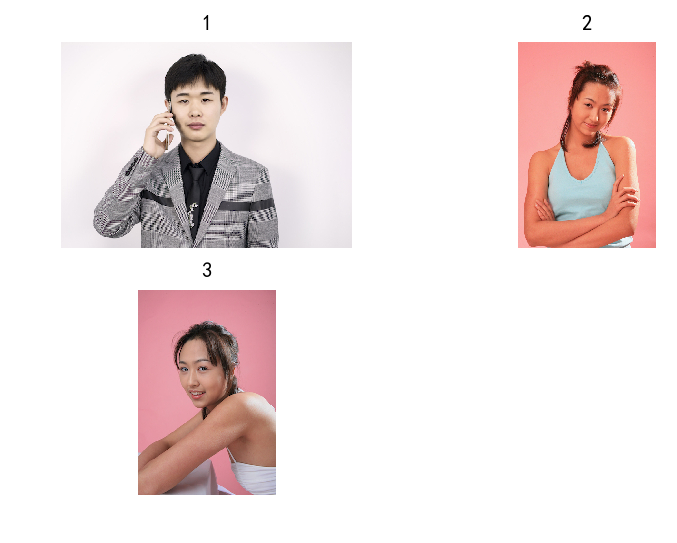

In [33]:
images_list =  ["./1.jpg","./2.jpg", "./3.jpg"]
images_names = ["1","2","3"]
show_images(images_list,images_names)

将所有的文件路径加入到image_path中

In [34]:
image_path = ["./1.jpg","./2.jpg","./3.jpg"]
image_name = ["1","2","3"]

### 检测人脸区域

我们使用`MTCNN`深度神经模型检测人脸区域。

In [35]:
minsize = 20 # minimum size of face
threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
factor = 0.709 # scale factor
tmp_image_paths=copy.copy(image_path)
img_list = [] 
mtcnn_list = []
with tf.Graph().as_default():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1.0)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    with sess.as_default():
        pnet, rnet, onet = detect_face.create_mtcnn(sess, None) # 创建 MTCNN 模型的三个子网络
margin = 44
image_size = 160
for image in tmp_image_paths:
    img = Image.open(image)
    img = np.array(img)
    img_size = np.asarray(img.shape)[0:2]
    # 得到人脸区域检测结果
    bounding_boxes, _ = detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
    if len(bounding_boxes) < 1:
        image_paths.remove(image)
        continue
    det = np.squeeze(bounding_boxes[0,0:4])
    bb = np.zeros(4, dtype=np.int32)
    bb[0] = np.maximum(det[0]-margin/2, 0)
    bb[1] = np.maximum(det[1]-margin/2, 0)
    bb[2] = np.minimum(det[2]+margin/2, img_size[1])
    bb[3] = np.minimum(det[3]+margin/2, img_size[0])
    cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
    mtcnn_list.append(cropped)
    aligned = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
    prewhitened = facenet.prewhiten(aligned)
    img_list.append(prewhitened)
images = np.stack(img_list)

/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


### 显示人脸区域

将MTCNN模型检测得到的人脸区域显示出来

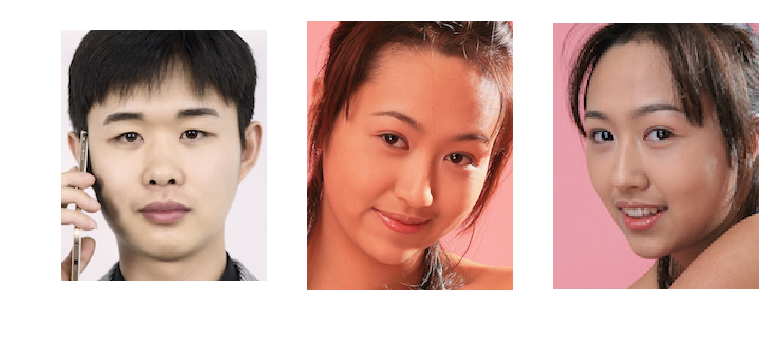

In [36]:
l = len(mtcnn_list)
line =  1
for i in range(l):
    plt.rcParams['savefig.dpi'] = 100 #图片像素
    plt.rcParams['figure.dpi'] = 150 #分辨率
    plt.subplot(1,l,i+1)
    plt.imshow(Image.fromarray(mtcnn_list[i]))
    plt.axis('off')
    plt.rcParams['font.sans-serif']=['SimHei']

### 计算人脸相似性

将人脸部分放入FaceNet模型，计算人脸之间的相似性。

相似性计算的原理是，计算人脸embeddings之间的欧式距离，距离越小代表越相似。

In [37]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        facenet.load_model("./20170512-110547/20170512-110547.pb")
        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        
        feed_dict = { images_placeholder: images, phase_train_placeholder:False }
        emb = sess.run(embeddings, feed_dict=feed_dict)
        nrof_images = len(image_path)

        data = []
        data_item = []
        for i in range(nrof_images):
            for j in range(nrof_images):
                if j<i:
                    data_item.append(""+str(image_name[i])+"&"+str(image_name[j]))
                    # 计算欧式距离
                    dist = np.sqrt(np.sum(np.square(np.subtract(emb[i,:], emb[j,:]))))
                    data.append(dist)

Instructions for updating:
Use tf.gfile.GFile.


Model filename: ./20170512-110547/20170512-110547.pb


### 绘制相似性计算结果

将相似性结果绘制出来。

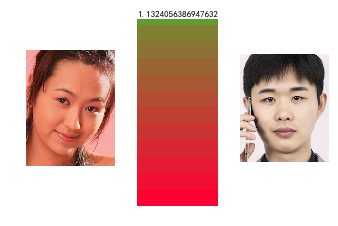

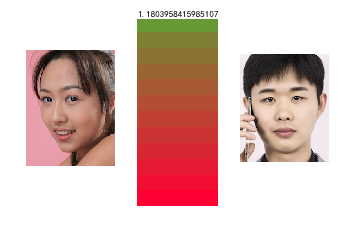

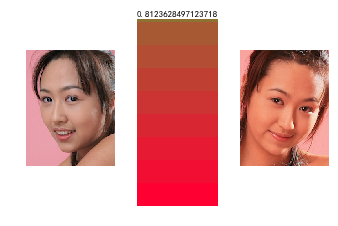

In [38]:
from matplotlib import gridspec
from matplotlib import pyplot as plt
index = 0
for face_0 in range(len(mtcnn_list)):
    for face_1 in range(len(mtcnn_list)):
        if face_1<face_0:
            score = data[index]

            plt.rcParams['savefig.dpi'] = 65 #图片像素
            plt.rcParams['figure.dpi'] = 65 #分辨率

            fig = plt.figure(constrained_layout=False)
            spec_0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

            f0_pic1 = fig.add_subplot(spec_0[0, 0])
            f0_pic1.imshow(Image.fromarray(mtcnn_list[face_0]))
            f0_pic1.axis('off')
            f0_score = fig.add_subplot(spec_0[0, 1])
            multi = math.floor(score/0.1)
            rema = score%0.1
            # 整0.1
            for i in range(multi):
                if i ==0 :
                    p = f0_score.bar(np.array(1), (0.1), 0.1,  color = (1,0,0.2))
                else:
                    p = f0_score.bar(np.array(1), (0.1), 0.1, bottom=(0.1*(i)), color = (1-0.05*(i),0+0.05*(i),0.2))
            # 0.1余数
            p = f0_score.bar(np.array(1), (rema), 0.1, bottom=(0.1*multi), color = (1-0.05*(multi+1),0+0.05*(multi+1),0.2))
            # 加入悬浮数字
            offset = {'center': 0.5, 'right': 0.57, 'left': 0.43} 
            ha = {'center': 'center', 'right': 'left', 'left': 'right'}
            height = data[index]
            for bar in p:
                f0_score.text(bar.get_x() + bar.get_width()*offset['center'], 1.01*height,
                        '{}'.format(height), ha=ha['center'], va='bottom')
            f0_score.axis('off')
            f2_pic1 = fig.add_subplot(spec_0[0, 2])
            f2_pic1.imshow(Image.fromarray(mtcnn_list[face_1]))
            f2_pic1.axis('off')
            index = index+1

图中表示两两对比中，数字越大代表人脸间差别越大，差别越大，色柱颜色变化越大。可以看到，
来自本人照片色柱变化最小，数值也最小，
而性别不同的对照组，色柱变化最大。

## 小结

本案例涉及的知识点：

* TensorFlow计算图操作
* MTCNN模型检测人脸区域
* FaceNet模型代码实现和训练，并抽取出人脸特征向量
